In [1]:
import os 
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
import tensorflow as tf
from tensorflow.keras.layers import Input, Reshape, Dropout, Dense 
from tensorflow.keras.layers import Flatten, BatchNormalization
from tensorflow.keras.layers import Activation, ZeroPadding2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam
import numpy as np
from PIL import Image
from tqdm import tqdm
import os 
import time
import matplotlib.pyplot as plt

2024-02-24 22:10:22.858365: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-24 22:10:22.858437: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-24 22:10:22.889816: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
GENERATE_RES = 4 # Generation resolution factor 
# (1=32, 2=64, 3=96, 4=128, etc.)
GENERATE_SQUARE = 32 * GENERATE_RES
IMAGE_CHANNELS = 3

# Preview image 
PREVIEW_ROWS = 1
PREVIEW_COLS = 7
PREVIEW_MARGIN = 16

# Size vector to generate images from
SEED_SIZE = 100

# Configuration
DATA_PATH = '/home/ksiva/datasets/celeba'
EPOCHS = 50
BATCH_SIZE = 32
BUFFER_SIZE = 60000

print(f"Will generate {GENERATE_SQUARE}px square images.")

Will generate 128px square images.


In [3]:
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)

In [4]:
training_binary_path = os.path.join(DATA_PATH, f'training_data_{GENERATE_SQUARE}_{GENERATE_SQUARE}.npy')

print(f"Looking for file: {training_binary_path}")

if not os.path.isfile(training_binary_path):
    start = time.time()
    print('Loading training images...')
    
    training_data = []
    faces_path = os.path.join(DATA_PATH, 'celeba_hq_256_jpeg')
    for filename in tqdm(os.listdir(faces_path)):
      path = os.path.join(faces_path, filename)
      image = Image.open(path).resize((GENERATE_SQUARE, GENERATE_SQUARE), Image.LANCZOS)
      training_data.append(np.asarray(image))

    start_reshape = time.time()
    print('Reshaping data...')
    training_data = np.reshape(training_data,(-1,GENERATE_SQUARE, GENERATE_SQUARE, IMAGE_CHANNELS))
    print(f'Reshaping is complete! Processing time: {(time.time() - start_reshape):.1f}s')

    start_dtype = time.time()
    print('Setting numpy dtype...')
    training_data = training_data.astype(np.float32)
    training_data = training_data / 127.5 - 1.
    print(f'Settings is complete! Processing time: {(time.time() - start_dtype):.1f}s')

    print("Saving training image binary...")
    np.save(training_binary_path, training_data)
    print (f'Image preprocess time: {time.time() - start:.1fs}')
    
else:
    print('Loading previous training pickle...')
    training_data = np.load(training_binary_path)

Looking for file: /home/ksiva/datasets/celeba/training_data_128_128.npy
Loading previous training pickle...


In [5]:
train_dataset = tf.data.Dataset.from_tensor_slices(training_data).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [6]:
def build_generator(seed_size, channels):
    return Sequential(
        [
            Dense(4*4*256, activation='relu', input_dim=seed_size),
            Reshape((4,4,256)),
            
            UpSampling2D(),
            Conv2D(256, kernel_size=3, padding='same'),
            BatchNormalization(momentum=0.8),
            Activation('relu'),

            UpSampling2D(),
            Conv2D(256, kernel_size=3, padding='same'),
            BatchNormalization(momentum=0.8),
            Activation('relu'),

            UpSampling2D(),
            Conv2D(128, kernel_size=3, padding='same'),
            BatchNormalization(momentum=0.8),
            Activation('relu'),

            UpSampling2D(size=(GENERATE_RES, GENERATE_RES)),
            Conv2D(128, kernel_size=3, padding='same'),
            BatchNormalization(momentum=0.8),
            Activation('relu'),

            Conv2D(channels, kernel_size=3, padding='same'),
            Activation('tanh')
        ]
    )


def build_discriminator(image_shape):
    return Sequential(
        [
            Conv2D(32, kernel_size=3, strides=2, input_shape=image_shape, padding='same'),
            LeakyReLU(alpha=0.2),

            Dropout(0.25),
            Conv2D(64, kernel_size=3, strides=2, padding='same'),
            ZeroPadding2D(padding=((0,1), (0,1))),
            BatchNormalization(momentum=0.8),
            LeakyReLU(alpha=0.2),

            Dropout(0.25),
            Conv2D(128, kernel_size=3, strides=2, padding='same'),
            BatchNormalization(momentum=0.8),
            LeakyReLU(alpha=0.2),

            Dropout(0.25),
            Conv2D(256, kernel_size=3, strides=1, padding='same'),
            BatchNormalization(momentum=0.8),
            LeakyReLU(alpha=0.2),

            Dropout(0.25),
            Conv2D(512, kernel_size=3, strides=1, padding='same'),
            BatchNormalization(momentum=0.8),
            LeakyReLU(alpha=0.2),

            Dropout(0.25),
            Flatten(),
            Dense(1, activation='sigmoid')
        ]
    )

In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy()

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [ ]:
noise = tf.random.normal([1, SEED_SIZE])
image_shape = (GENERATE_SQUARE,GENERATE_SQUARE,IMAGE_CHANNELS)

In [9]:
generator = build_generator(SEED_SIZE, IMAGE_CHANNELS)
generator_optimizer = tf.keras.optimizers.Adam(1.5e-4,0.5)

/home/ksiva/miniconda3/envs/keras-cv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(
/home/ksiva/miniconda3/envs/keras-cv/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


tf.Tensor([[0.49943474]], shape=(1, 1), dtype=float32)


In [ ]:
discriminator = build_discriminator(image_shape)
discriminator_optimizer = tf.keras.optimizers.Adam(1.5e-4,0.5)

In [12]:
@tf.function
def train_step(images):
    seed = tf.random.normal([BATCH_SIZE, SEED_SIZE])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(seed, training=True)
        
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)
        
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
        
        
        gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
        
        generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
        discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
        
    return gen_loss,disc_loss

In [13]:
def train(dataset, epochs):
    start = time.time()
    
    for epoch in range(epochs):
        epoch_start = time.time()
        
        gen_loss_list = []
        disc_loss_list = []
        
        for image_batch in dataset:
            t = train_step(image_batch)
            gen_loss_list.append(t[0])
            disc_loss_list.append(t[1])

        g_loss = sum(gen_loss_list) / len(gen_loss_list)
        d_loss = sum(disc_loss_list) / len(disc_loss_list)

        print(f'Epoch {epoch + 1}/{epochs}\n'\
              f'{time.time() - epoch_start:.1f}s - generator loss: {g_loss:.4f}, discriminator loss: {d_loss:.4f}')

    print (f'Training time: {time.strftime("%-H\h %-M\m %-S\s", time.gmtime(time.time() - start)}')

In [14]:
train(train_dataset, EPOCHS)

2024-02-24 22:11:56.489254: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1_2/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-02-24 22:14:29.679057: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1_2/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 1, gen loss=4.301653861999512,disc loss=1.4026376008987427, 0:02:41.33
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


I0000 00:00:1708802075.070414   44678 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Epoch 2, gen loss=3.5853769779205322,disc loss=1.1826478242874146, 0:02:21.78
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Epoch 3, gen loss=3.9985389709472656,disc loss=1.0291005373001099, 0:02:21.88
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Epoch 4, gen loss=3.7693562507629395,disc loss=1.021296739578247, 0:02:22.88
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Epoch 5, gen loss=3.8966176509857178,disc loss=0.8981260061264038, 0:02:22.62
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Epoch 6, gen loss=3.8393614292144775,disc loss=0.8849776387214661, 0:02:22.53
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Epoch 7, gen loss=3.587669610977173,disc loss=0.8923118710517883, 0:02:22.48
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Epoch 8, gen loss=3.455367088317871,disc loss=0.8472915887832642, 0:02:22.98
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Epoch 9, gen loss=3.717075824737549,disc loss=0.8265472054481506, 0:02:24.35
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Epoch 10, gen loss=3.719496965408325,disc loss=0.7674654722213745, 0:02:23.3

In [15]:
print(time.time())

1708810213.7949133


In [18]:
start = time.time()

In [22]:
time.strftime("%-Hh %-Mm %-Ss", time.gmtime(time.time() - start))

'0h 0m 17s'

In [26]:
time.strftime("%Y-%m-%d-%H-%M")

'2024-02-25_00-35'

In [29]:
generator.save(os.path.join(DATA_PATH, f'face_generator_{time.strftime("%Y-%m-%d-%H-%M")}.h5'))
generator.save(os.path.join(DATA_PATH, f'face_generator_{time.strftime("%Y-%m-%d-%H-%M")}.keras'))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


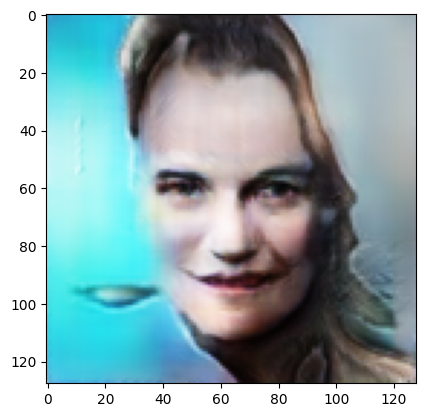

In [67]:
noise = tf.random.normal([1, SEED_SIZE])
generated_image = generator.predict(noise)
generated_image = 0.5 * generated_image + 0.5

plt.imshow(generated_image[0])

In [71]:
def save_images(cnt, noise):
    image_array = np.full((
        PREVIEW_MARGIN + (PREVIEW_ROWS * (GENERATE_SQUARE+PREVIEW_MARGIN)),
        PREVIEW_MARGIN + (PREVIEW_COLS * (GENERATE_SQUARE+PREVIEW_MARGIN)), IMAGE_CHANNELS),
                    255, dtype=np.uint8)
  
    generated_images = generator.predict(noise)
    
    generated_images = 0.5 * generated_images + 0.5
    
    image_count = 0
    for row in range(PREVIEW_ROWS):
        for col in range(PREVIEW_COLS):
            r = row * (GENERATE_SQUARE+16) + PREVIEW_MARGIN
            c = col * (GENERATE_SQUARE+16) + PREVIEW_MARGIN
            image_array[r:r+GENERATE_SQUARE,c:c+GENERATE_SQUARE] = generated_images[image_count] * 255
            image_count += 1

    output_path = os.path.join(DATA_PATH, 'output')
    if not os.path.exists(output_path):
        os.makedirs(output_path)
  
    filename = os.path.join(output_path,f"train-{cnt}.png")
    im = Image.fromarray(image_array)
    im.save(filename)

In [72]:
save_images(60, np.random.normal(0, 1, (PREVIEW_ROWS * PREVIEW_COLS, SEED_SIZE)))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
